In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [5]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [6]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [7]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/2025ML+DL Programming/dataset/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/2025ML+DL Programming/dataset/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [8]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [9]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

In [12]:
from tensorflow.keras import models, layers

SimpleLSTMModel = models.Sequential([
    layers.LSTM(128, input_shape=(n_timesteps, n_features), return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_outputs, activation='softmax')
])

SimpleLSTMModel.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

SimpleLSTMModel.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,158 (504.52 KB)

 Trainable params: 129,158 (504.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
SimpleCNNModel = models.Sequential([
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps, n_features)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=7, activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_outputs, activation='softmax')
])

SimpleCNNModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
SimpleCNNModel.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 128, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 64, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 32, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,301,190 (8.78 MB)

 Trainable params: 2,301,190 (8.78 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = SimpleLSTMModel.fit(x=[X_train,X_train,X_train,X_train], y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4890 - loss: 1.2298 - val_accuracy: 0.5976 - val_loss: 0.9700
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6372 - loss: 0.8648 - val_accuracy: 0.7317 - val_loss: 0.5856
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7837 - loss: 0.5468 - val_accuracy: 0.8268 - val_loss: 0.4220
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8401 - loss: 0.4315 - val_accuracy: 0.8149 - val_loss: 0.3971
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8805 - loss: 0.3244 - val_accuracy: 0.8947 - val_loss: 0.2954
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9303 - loss: 0.2105 - val_accuracy: 0.9440 - val_loss: 0.1430
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9381 - loss: 0.1763 - val_accuracy: 0.9355 - val_loss: 0.1887
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9082 - loss: 0.2695 - val_accuracy: 0.957

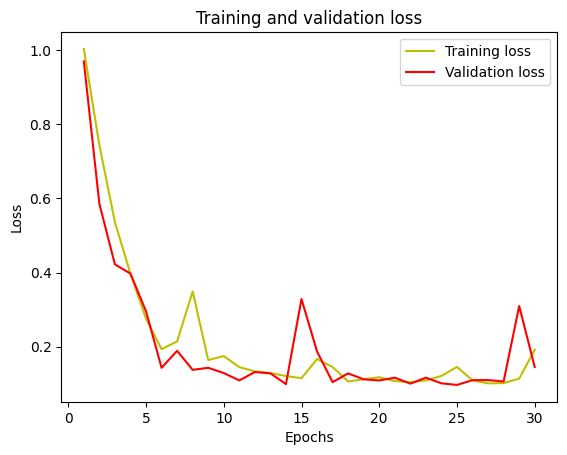

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

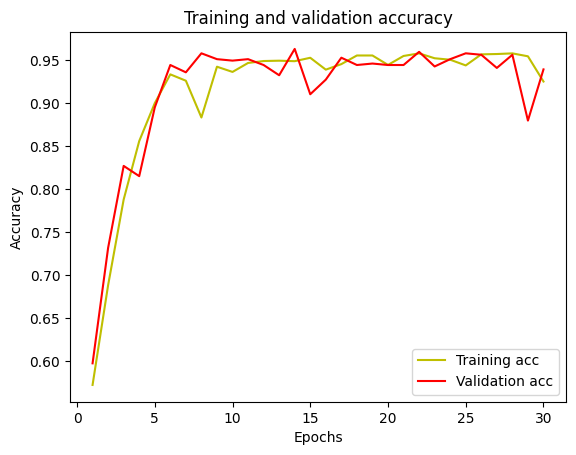

In [15]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
[[423  22  50   0   1   0]
 [  0 460  11   0   0   0]
 [  2   0 418   0   0   0]
 [  0   1   0 300 183   7]
 [  0   0   0  24 508   0]
 [  0   0   0   0   0 537]]
0.8978622327790974
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       496
           1       0.95      0.98      0.96       471
           2       0.87      1.00      0.93       420
           3       0.93      0.61      0.74       491
           4       0.73      0.95      0.83       532
           5       0.99      1.00      0.99       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.89      2947



<Axes: >

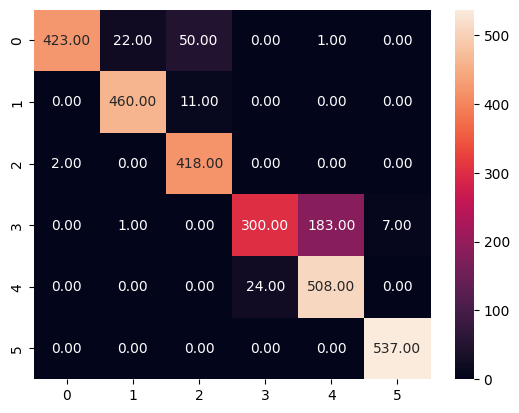

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=SimpleLSTMModel.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')